<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/8_Forecast_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

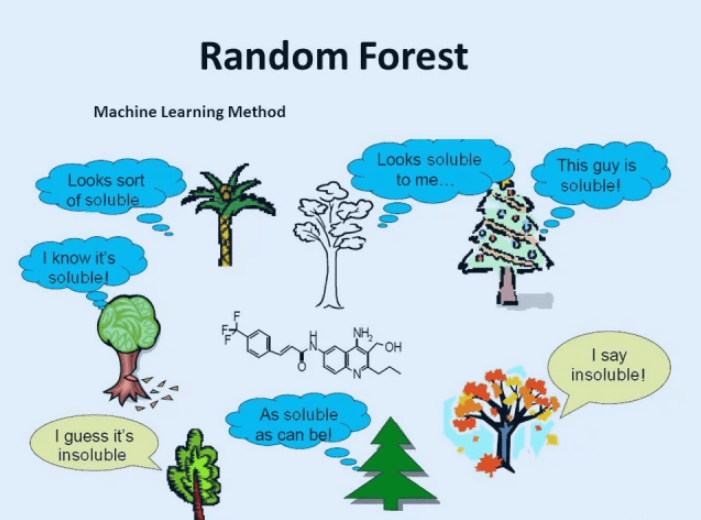

# Pronósticos con Bosques Aleatorios

Random Forest también se puede utilizar para el pronóstico de series de tiempo , aunque requiere que el conjunto de datos de la serie de tiempo se transforme primero en un problema de aprendizaje supervisado. También requiere el uso de una técnica especializada para evaluar el modelo llamada validación de avance, ya que evaluar el modelo utilizando una validación cruzada de k veces daría como resultado resultados sesgados de manera optimista.

1. Random Forest es un conjunto de algoritmos de árboles de decisión que se pueden utilizar para modelos predictivos de clasificación y regresión.

2. Los conjuntos de datos de series temporales se pueden transformar en aprendizaje supervisado mediante una representación de ventana deslizante.

3. Cómo ajustar, evaluar y hacer predicciones con un modelo de regresión de bosque aleatorio para pronósticos de series temporales.

### Librerías y Conversión de Datos

In [ ]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Con esta función, hemos definido la secuencia de entrada, la secuencia de pronóstico y las hemos concatenado. Además, hemos eliminado todos los valores NaN. También convierte una serie de tiempo en datos de aprendizaje supervisados.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

### Preparación de los datos

In [ ]:
# Se define una función que puede dividir el conjunto de datos.
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

### Ajuste del modelo
En esta sección, definiremos una función que puede ayudar a ajustar los datos convertidos mediante el modelo de regresión de bosque aleatorio.

In [ ]:
# Ajusta un modelo de bosque aleatorio y realiza una predicción de un paso
def random_forest_forecast(train, X_test):
    train = np.asarray(train)
    X_train, y_train = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(X_train, y_train)
    y_hat = model.predict([X_test])
    return y_hat[0]

### Validación para datos univariados
Esta función transforma una lista en una arreglo, luego divide los datos y se
ajusta al modelo. Después de entrenar el modelo, nos ayudará a realizar
predicciones de un solo paso.

In [ ]:
# Esta sección utilizará todas las funciones mencionadas anteriormente y
# ajustará los datos de prueba a un modelo para predecir y verificar la
# precisión del modelo.

def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

### Cargando los datos
Esto cargará los datos y, utilizando la función anterior, convertiremos los datos en datos de aprendizaje supervisados.

Un conjunto de datos que representa el número total de nacimientos de mujeres registrados en California, EE. UU. durante el año 1959.

In [ ]:
# Lectura de datos
series = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/daily-total-female-births.csv', header=0, index_col=0)

### Gráfico de los datos



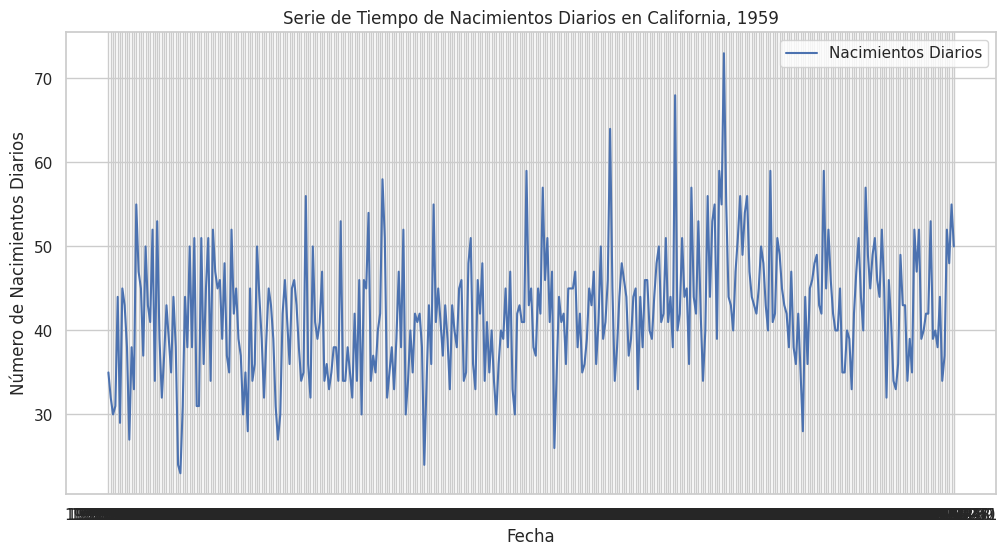

In [ ]:
sns.set(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x = series.index, y=series['Births'], label='Nacimientos Diarios')

# Configurar el título y las etiquetas de los ejes
plt.title('Serie de Tiempo de Nacimientos Diarios en California, 1959')
plt.xlabel('Fecha')
plt.ylabel('Número de Nacimientos Diarios')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

### Funciones ACF y PACF

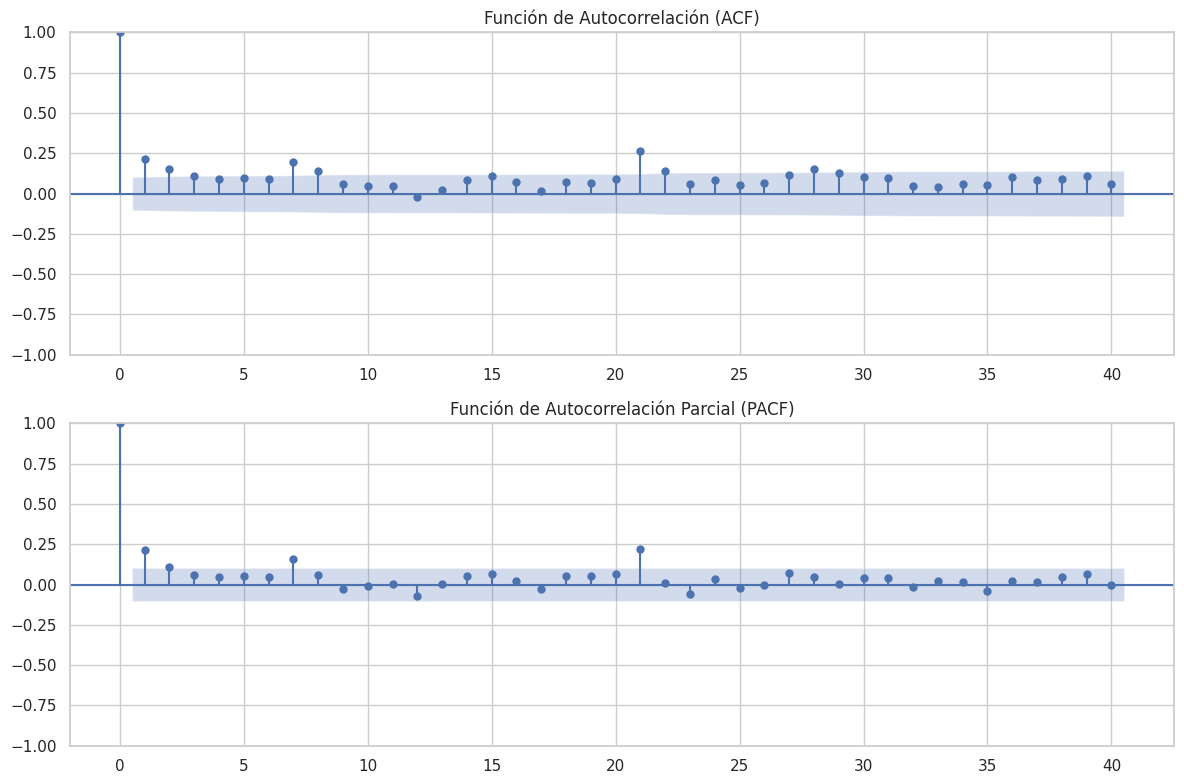

In [ ]:
# Graficar la ACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, ax=ax[0], lags=40)
ax[0].set_title('Función de Autocorrelación (ACF)')

# Graficar la PACF
plot_pacf(series, ax=ax[1], lags=40, method='ywm')
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
# Visualización de datos
series.head(10)

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
1959-01-06,29
1959-01-07,45
1959-01-08,43
1959-01-09,38


In [ ]:
# Valores de la serie
values = series.values

In [ ]:
# Datos preparados para modelo supervisado. El valor de n_in=7, fue sacado de la ACF y PACF
data = series_to_supervised(values, n_in=6)
data

array([[35., 32., 30., ..., 44., 29., 45.],
       [32., 30., 31., ..., 29., 45., 43.],
       [30., 31., 44., ..., 45., 43., 38.],
       ...,
       [40., 38., 44., ..., 37., 52., 48.],
       [38., 44., 34., ..., 52., 48., 55.],
       [44., 34., 37., ..., 48., 55., 50.]])

### Evaluación del modelo

In [ ]:
# Realiza la validación walk-forward con MAPE
mape, actual, predicted = walk_forward_validation(data, 12)

# Imprime el MAPE
print('MAPE: %.3f' % mape)

>expected=42.0, predicted=45.0
>expected=53.0, predicted=43.6
>expected=39.0, predicted=41.5
>expected=40.0, predicted=38.6
>expected=38.0, predicted=43.0
>expected=44.0, predicted=48.4
>expected=34.0, predicted=42.5
>expected=37.0, predicted=36.6
>expected=52.0, predicted=38.1
>expected=48.0, predicted=41.7
>expected=55.0, predicted=43.6
>expected=50.0, predicted=45.3
MAPE: 5.912


In [ ]:
# Realiza la validación walk-forward con MAE
mae, actual, predicted = walk_forward_validation(data, 12)

# Imprime el MAE
print('MAE: %.3f' % mae)

>expected=42.0, predicted=45.4
>expected=53.0, predicted=43.7
>expected=39.0, predicted=41.6
>expected=40.0, predicted=38.8
>expected=38.0, predicted=42.7
>expected=44.0, predicted=47.7
>expected=34.0, predicted=42.7
>expected=37.0, predicted=37.0
>expected=52.0, predicted=38.1
>expected=48.0, predicted=42.1
>expected=55.0, predicted=43.5
>expected=50.0, predicted=44.9
MAE: 5.832


### Gráfico de los pronósticos y reales

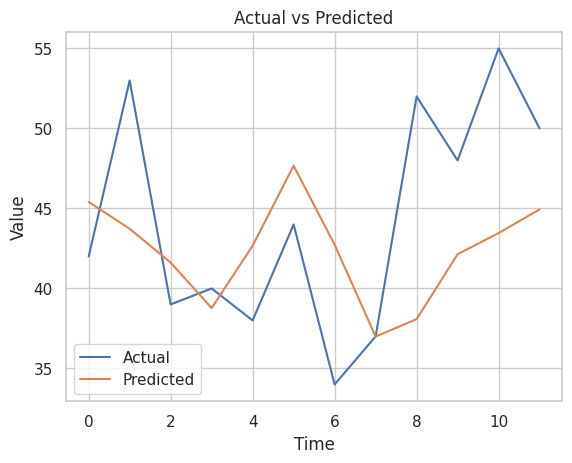

In [ ]:
# En el resultado anterior, podemos ver que tenemos un MAE de 5,785. Esto es un
# buen indicador. Grafiquemos estas predicciones con datos de prueba.
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.show()

### Conclusión
Aquí podemos ver los valores predichos por el modelo de regresión de bosque aleatorio ajustado. Para un mejor rendimiento, podemos cambiar los parámetros del modelo de regresión de bosque aleatorio.